# Generating dataset 

In [ ]:
# set current directory (where this repo is located)
import os
PROJECT_ROOT = '/home/young/workspace/reconstruction/recon-mnistc'
os.chdir(PROJECT_ROOT)
print('current directory:', os.getcwd())

In [1]:
%matplotlib inline 
import matplotlib.pyplot as plt

import torch
import torchvision.transforms as T
from torchvision import datasets
import copy
import os
from tqdm.notebook import tqdm
import numpy as np 
np.set_printoptions(suppress=True)

import random

# Mnist with pixel shift (translation only)
- we allowed upto 2 pixels shifts with zeropadding as done in original capsnet paper, Sabour 2017)

In [14]:
def get_tensorized_dataset(im_set):
    images = []
    labels = []
    for img, label in im_set:
        img = np.array(img)
        images.append(img)    
        labels.append(label)
        
    # convert to tensor and one-hot vector
    transform_tohot = T.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
    images_tensorized = torch.stack([T.ToTensor()(im) for im in images])
    labels_tensorized = torch.stack([transform_tohot(label) for label in labels])
    
    return images_tensorized, labels_tensorized

def plot(imgs, num_rows = 1, with_orig=False, row_title=None, **imshow_kwargs):
#     if not isinstance(imgs, list):
#         raise ValueError('input images should be list form')

    num_cols = int(len(imgs)/num_rows) + (len(imgs)%num_rows > 0)
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
#     import pdb; pdb.set_trace()
    for row_idx in range(num_rows):
        for col_idx, img in enumerate(imgs[row_idx*num_cols:(row_idx+1)*num_cols]):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), cmap='gray', vmin=0, vmax=1,  **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

#     if with_orig:
#         axs[0, 0].set(title='Original image')
#         axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])
    plt.show()
#     plt.tight_layout()

# load original mnist
path_save = '../data/MNIST_shift'
dataset_type = 'train'


if dataset_type == 'train':
    im_set = datasets.MNIST('../data/',train=True, download=False)
elif dataset_type == 'test':
    im_set = datasets.MNIST('../data/',train=False, download=False)

orig_images_tensorized, orig_labels_tensorized = get_tensorized_dataset(im_set)
print(orig_images_tensorized.size())
print(orig_labels_tensorized.size())

torch.Size([60000, 1, 28, 28])
torch.Size([60000, 10])


In [15]:
# shifted version version
max_portion = [0.08, 0.08] # this corresponds to upto 2 pixel changes of 28x28 image when round up; sourcecode: https://pytorch.org/vision/stable/generated/torchvision.transforms.RandomAffine.html#torchvision.transforms.RandomAffine

transforms = T.Compose([ T.RandomAffine(degrees=0, translate=max_portion), T.ToTensor()])

if dataset_type == 'train':
    im_set = datasets.MNIST('../data/',train=True, download=False, transform=transforms,
                        target_transform=T.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)))
elif dataset_type == 'test':
    im_set = datasets.MNIST('../data/',train=False, download=False, transform=transforms,
                        target_transform=T.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)))

    
images = []
# labels = []
for img, label in im_set:
    images.append(img)    
#     labels.append(label)
        
shift_images_tensorized = torch.stack([im for im in images])
print(shift_images_tensorized.size())

torch.Size([60000, 1, 28, 28])


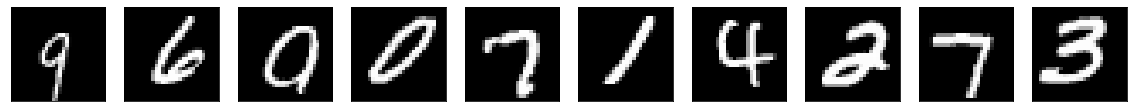

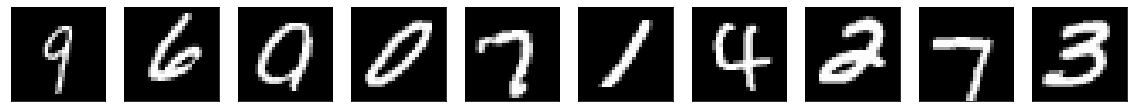

[tensor(9), tensor(6), tensor(9), tensor(0), tensor(7), tensor(1), tensor(4), tensor(2), tensor(7), tensor(3)]


In [16]:
# visualize erased images
plt.rcParams["figure.figsize"] = (20,3)
i =90#152
plottedimgs = [torch.movedim(shift_images_tensorized[i], 0 ,-1) for i in range(10*i,10*(i+1))]
plot(plottedimgs, num_rows=1)
plottedimgs = [torch.movedim(orig_images_tensorized[i], 0 ,-1) for i in range(10*i,10*(i+1))]
plot(plottedimgs, num_rows=1)
print([l.argmax() for l in orig_labels_tensorized[10*i:10*(i+1)]])

In [17]:
# save tensors 
filename = os.path.join(path_save, f'{dataset_type}_shift_by_2pixel.pt')
torch.save((shift_images_tensorized, orig_labels_tensorized), filename)
print(f'{filename} saved to disk')


../data/MNIST_shift/train_shift_by_2pixel.pt saved to disk


# c.f. affine augmentation


In [4]:
def get_tensorized_dataset(im_set):
    images = []
    labels = []
    for img, label in im_set:
        img = np.array(img)
        images.append(img)    
        labels.append(label)
        
    # convert to tensor and one-hot vector
    transform_tohot = T.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1))
    images_tensorized = torch.stack([T.ToTensor()(im) for im in images])
    labels_tensorized = torch.stack([transform_tohot(label) for label in labels])
    
    return images_tensorized, labels_tensorized

def plot(imgs, num_rows = 1, with_orig=False, row_title=None, **imshow_kwargs):
#     if not isinstance(imgs, list):
#         raise ValueError('input images should be list form')

    num_cols = int(len(imgs)/num_rows) + (len(imgs)%num_rows > 0)
    fig, axs = plt.subplots(nrows=num_rows, ncols=num_cols, squeeze=False)
#     import pdb; pdb.set_trace()
    for row_idx in range(num_rows):
        for col_idx, img in enumerate(imgs[row_idx*num_cols:(row_idx+1)*num_cols]):
            ax = axs[row_idx, col_idx]
            ax.imshow(np.asarray(img), cmap='gray', vmin=0, vmax=1,  **imshow_kwargs)
            ax.set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

#     if with_orig:
#         axs[0, 0].set(title='Original image')
#         axs[0, 0].title.set_size(8)
    if row_title is not None:
        for row_idx in range(num_rows):
            axs[row_idx, 0].set(ylabel=row_title[row_idx])
    plt.show()
#     plt.tight_layout()

# load original mnist
dataset_type = 'test'


if dataset_type == 'train':
    im_set = datasets.MNIST('../data/',train=True, download=False)
elif dataset_type == 'test':
    im_set = datasets.MNIST('../data/',train=False, download=False)

orig_images_tensorized, orig_labels_tensorized = get_tensorized_dataset(im_set)
print(orig_images_tensorized.size())
print(orig_labels_tensorized.size())



torch.Size([10000, 1, 28, 28])
torch.Size([10000, 10])


In [51]:
transforms = T.Compose([  T.RandomAffine(degrees=30, translate=(0.08, 0.08), scale=(0.7, 1.0), shear=30), T.ToTensor()])

if dataset_type == 'train':
    im_set = datasets.MNIST('../data/',train=True, download=False, transform=transforms,
                        target_transform=T.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)))
elif dataset_type == 'test':
    im_set = datasets.MNIST('../data/',train=False, download=False, transform=transforms,
                        target_transform=T.Lambda(lambda y: torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)))

    
images = []
# labels = []
for img, label in im_set:
    images.append(img)    
#     labels.append(label)
        
shift_images_tensorized = torch.stack([im for im in images])
print(shift_images_tensorized.size())

torch.Size([10000, 1, 28, 28])


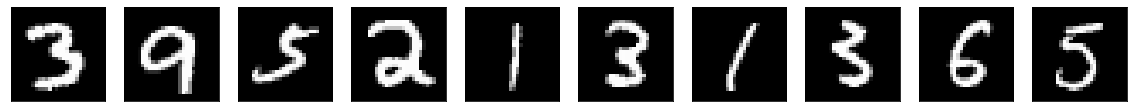

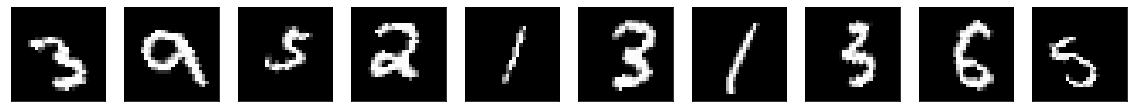

[tensor(3), tensor(9), tensor(5), tensor(2), tensor(1), tensor(3), tensor(1), tensor(3), tensor(6), tensor(5)]


In [55]:
# visualize erased images
plt.rcParams["figure.figsize"] = (20,3)
i =50#152
plottedimgs = [torch.movedim(orig_images_tensorized[i], 0 ,-1) for i in range(10*i,10*(i+1))]
plot(plottedimgs, num_rows=1)
plottedimgs = [torch.movedim(shift_images_tensorized[i], 0 ,-1) for i in range(10*i,10*(i+1))]
plot(plottedimgs, num_rows=1)

print([l.argmax() for l in orig_labels_tensorized[10*i:10*(i+1)]])